In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_hub as hub

from keras_preprocessing.image import ImageDataGenerator
from keras.utils.vis_utils import plot_model

In [2]:
input_dir = '/kaggle/input'

sample_dir = os.path.join(input_dir, 'sample/')
csv_dir = os.path.join(input_dir, 'nihsample')
images_dir = os.path.join(sample_dir, 'sample/sample/images')

In [3]:
training_file = os.path.join(csv_dir, 'train_data.csv')
testing_file = os.path.join(csv_dir, 'test_data.csv')

In [4]:
training_df = pd.read_csv(training_file, index_col=0)
testing_df = pd.read_csv(testing_file, index_col=0)

In [5]:
training_df['pneumonia'] = training_df['pneumonia'].astype(str)
testing_df['pneumonia'] = testing_df['pneumonia'].astype(str)

In [6]:
di = {'0': "NORMAL", '1': "PNEUMONIA"}

training_df['pneumonia'].replace(di, inplace=True)
testing_df['pneumonia'].replace(di, inplace=True)

In [7]:
batch_size = 64
image_size = (224, 224)

In [8]:
train_datagen = ImageDataGenerator(
    rescale=1./255.,  
    horizontal_flip = True, 
    vertical_flip = False, 
    height_shift_range= 0.1, 
    width_shift_range=0.1, 
    rotation_range=30,
    shear_range = 0.1,
    zoom_range=0.2,
    validation_split=0.2
)

test_datagen = ImageDataGenerator(rescale=1./255.)

In [9]:
train_generator=train_datagen.flow_from_dataframe(
    dataframe=training_df,
    directory=images_dir,
    x_col="image_index",
    y_col='pneumonia', 
    batch_size=batch_size,
    seed=42,
    shuffle=True,
    class_mode='categorical',
    target_size=image_size,
    subset='training',
    color_mode='rgb', 
    classes=['NORMAL', 'PNEUMONIA']
)

valid_generator=train_datagen.flow_from_dataframe(
    dataframe=training_df,
    directory=images_dir,
    x_col="image_index",
    y_col='pneumonia', 
    batch_size=batch_size,
    seed=42,
    shuffle=False,
    class_mode='categorical',
    target_size=image_size,
    subset='validation',
    color_mode='rgb', 
    classes=['NORMAL', 'PNEUMONIA']
)

test_generator=test_datagen.flow_from_dataframe(
    dataframe=testing_df,
    directory=images_dir,
    x_col="image_index",
    y_col='pneumonia',
    batch_size=batch_size,
    seed=42,
    shuffle=False,
    class_mode='categorical',
    target_size=image_size,
    color_mode='rgb', 
    classes=['NORMAL', 'PNEUMONIA']
)

Found 3588 validated image filenames belonging to 2 classes.
Found 897 validated image filenames belonging to 2 classes.
Found 1121 validated image filenames belonging to 2 classes.


In [10]:
num_classes = 2

In [11]:
URL = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4"

IMG_WIDTH, IMG_HEIGHT = image_size

feature_extractor = hub.KerasLayer(URL, input_shape=(IMG_WIDTH, IMG_HEIGHT, 3))

feature_extractor.trainable = False

In [12]:
model = tf.keras.Sequential([
        feature_extractor,
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(2156, activation = 'relu'),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(1280, activation = 'relu'),
        tf.keras.layers.Dropout(0.4),
        tf.keras.layers.Dense(540, activation = 'relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(num_classes, activation = 'softmax')
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 2048)              23564800  
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 2156)              4417644   
_________________________________________________________________
dropout_1 (Dropout)          (None, 2156)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1280)              2760960   
_________________________________________________________________
dropout_2 (Dropout)          (None, 1280)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 540)               6

In [13]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [14]:
loss, accuracy = model.evaluate(test_generator)

print('\nLoss before training: {:,.3f}'.format(loss))
print('Accuracy before training: {:.3%}'.format(accuracy))

18/18 [==============================] - 20s 1s/step - loss: 0.9580 - accuracy: 0.4853

Loss before training: 0.958
Accuracy before training: 48.528%


In [15]:
EPOCHS = 100

model_file = os.path.join('model.h5')

early_stopping = tf.keras.callbacks.EarlyStopping(
                    monitor='val_loss', 
                    patience=5,
                    restore_best_weights=True
                 )

save_best = tf.keras.callbacks.ModelCheckpoint(
                model_file, 
                monitor='val_accuracy', 
                save_best_only=True
            )

history = model.fit(
    train_generator, 
    epochs = EPOCHS, 
    validation_data=valid_generator, 
    callbacks=[early_stopping, save_best]
)

Epoch 1/100
57/57 [==============================] - 140s 2s/step - loss: 0.9397 - accuracy: 0.5438 - val_loss: 0.6162 - val_accuracy: 0.6800
Epoch 2/100
57/57 [==============================] - 131s 2s/step - loss: 0.6343 - accuracy: 0.6502 - val_loss: 0.5718 - val_accuracy: 0.7469
Epoch 3/100
57/57 [==============================] - 131s 2s/step - loss: 0.5840 - accuracy: 0.6870 - val_loss: 0.5340 - val_accuracy: 0.7469
Epoch 4/100
57/57 [==============================] - 132s 2s/step - loss: 0.5319 - accuracy: 0.7341 - val_loss: 0.4807 - val_accuracy: 0.8038
Epoch 5/100
57/57 [==============================] - 131s 2s/step - loss: 0.4747 - accuracy: 0.7768 - val_loss: 0.4021 - val_accuracy: 0.8071
Epoch 6/100
57/57 [==============================] - 131s 2s/step - loss: 0.4457 - accuracy: 0.7929 - val_loss: 0.3734 - val_accuracy: 0.8372
Epoch 7/100
57/57 [==============================] - 131s 2s/step - loss: 0.4288 - accuracy: 0.7979 - val_loss: 0.3678 - val_accuracy: 0.8138
Epoch 

In [16]:
loss, accuracy = model.evaluate(test_generator)

print('\nLoss after training: {:,.3f}'.format(loss))
print('Accuracy after training: {:.3%}'.format(accuracy))

18/18 [==============================] - 19s 1s/step - loss: 0.0326 - accuracy: 0.9857

Loss after training: 0.033
Accuracy after training: 98.573%


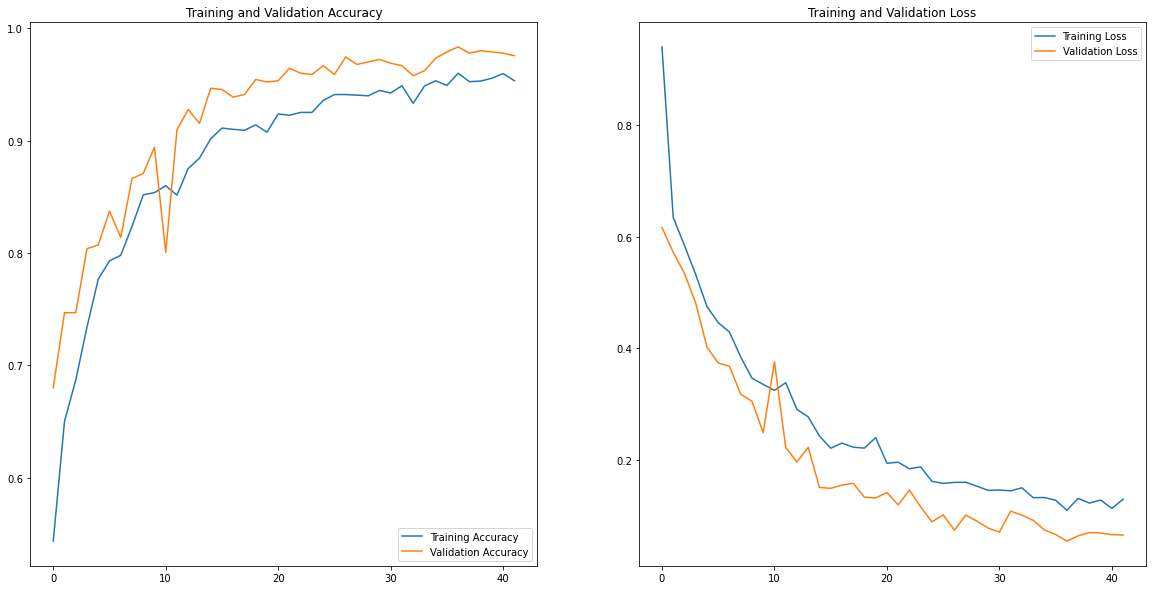

In [17]:
training_accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']

training_loss = history.history['loss']
validation_loss = history.history['val_loss']

epochs_range=range(len(training_accuracy))

plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, training_accuracy, label='Training Accuracy')
plt.plot(epochs_range, validation_accuracy, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, training_loss, label='Training Loss')
plt.plot(epochs_range, validation_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [18]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve

In [19]:
batch_size = 64
num_of_test_samples = 1121

In [20]:
Y_pred = model.predict_generator(test_generator, num_of_test_samples // batch_size+1, verbose = 1)
y_pred = np.argmax(Y_pred, axis=1)

18/18 [==============================] - 18s 1s/step


In [21]:
print('Confusion Matrix')
print(confusion_matrix(test_generator.classes, y_pred, labels=[0, 1]))

Confusion Matrix
[[563  16]
 [  0 542]]


In [22]:
print('Classification Report')
target_names = ['Normal', 'Pneumonia']
print(classification_report(test_generator.classes, y_pred, target_names=target_names))

Classification Report
              precision    recall  f1-score   support

      Normal       1.00      0.97      0.99       579
   Pneumonia       0.97      1.00      0.99       542

    accuracy                           0.99      1121
   macro avg       0.99      0.99      0.99      1121
weighted avg       0.99      0.99      0.99      1121



In [23]:
roc_auc_score(test_generator.classes, y_pred)

0.9861830742659758

In [24]:
fpr, tpr, thresholds = roc_curve(test_generator.classes, y_pred, pos_label=1)

fpr, tpr, thresholds 

(array([0.        , 0.02763385, 1.        ]),
 array([0., 1., 1.]),
 array([2, 1, 0]))